# Volumetric inverse rendering with transient image data

In [1]:
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi
from importlib import reload

mi.set_variant('llvm_ad_rgb')

## Creating multiple sensors

Use 5 sensors placed on a half circle around the origin.

In [2]:
from mitsuba import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'transient': True,
        'num_films': 8,
        'film': {
            'type': 'hdrfilm',
            'width': 64, 'height': 64,
            'filter': {'type': 'tent'}
        }
    }))

## Rendering synthetic reference images

Setup a simple scene with a constant environment illumination and a reference volume placed at the origin. The heterogenous volume is instantiated inside of a cube. We assign the `null` BSDF to the cube's surface, since we do not want the cube's surface to interact with light in any way (i.e., the surface should be invisible). To learn more about volume rendering in Mitsuba, please refer to the [plugin documentation][1].

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous

In [12]:
import integrators.transientvolpathsimple
reload(integrators.transientvolpathsimple)

scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'transientvolpathsimple',
        'max_depth': 64,
        'use_drt': True,
        'dt': 0.2
    },
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': '../scenes/volume.vol',
                'to_world': T.rotate([1, 0, 0], -90).scale(2).translate(-0.5)
            },
            'scale': 40
        }
    },
    'emitter': {'type': 'constant'}
}

scene_ref = mi.load_dict(scene_dict)

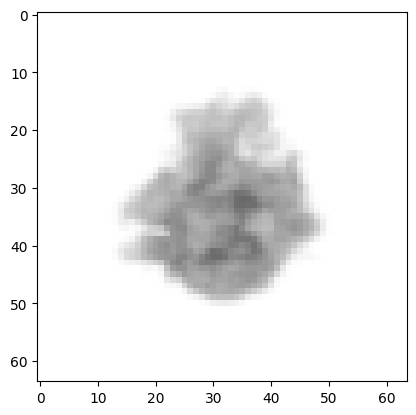

In [4]:
ref_im_transient = [mi.render(scene_ref, sensor=sensors[i], spp=512) for i in range(sensor_count)]
ref_im = ref_im_transient[0][0]
plt.imshow(mi.util.convert_to_bitmap(ref_im))

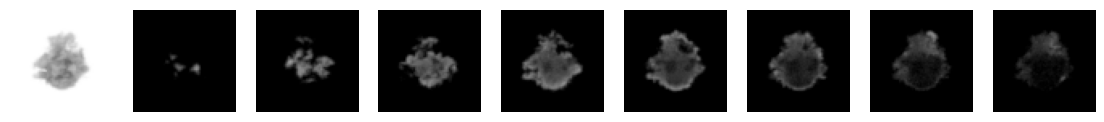

In [7]:
fig, axs = plt.subplots(1, ref_im_transient[0].shape[0], figsize=(14, 4))
for i in range(ref_im_transient[0].shape[0]):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_im_transient[0][i]))
    axs[i].axis('off')

## Setting up the optimization scene
Replace the reference volume by a simple uniform initialization. To initialize a volume grid from Python, we use the [<code>VolumeGrid</code>][2] object in conjunction with [<code>TensorXf</code>][3]. The `VolumeGrid` class is responsible for loading and writing volumes from disk, similar to the `Bitmap` class for images. Using the `grid` property of the [<code>gridvolume</code>][4] plugin, it is possible to pass it directly to the plugin constructor in Python.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.VolumeGrid
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf
[4]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_media.html#grid-based-volume-data-source-gridvolume

In [15]:
v_res = 8

# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': T.translate(-1).scale(2.0)
        },
        'scale': 40.0,
    },
    'bsdf': {'type': 'null'}
}

scene = mi.load_dict(scene_dict)

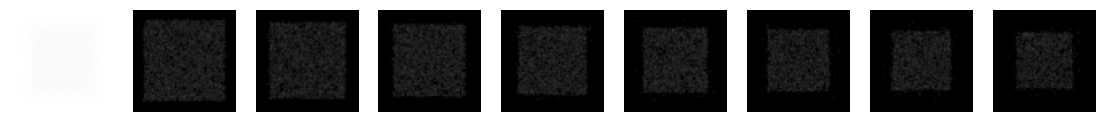

In [9]:
# Render scene initialization
init_im_transient = mi.render(scene, sensor=sensors[0], spp=128)

fig, axs = plt.subplots(1, init_im_transient.shape[0], figsize=(14, 4))
for i in range(init_im_transient.shape[0]):
    axs[i].imshow(mi.util.convert_to_bitmap(init_im_transient[i]))
    axs[i].axis('off')

## Optimization

In [17]:
# Instantiate optimizer and set parameter to be optimized
params = mi.traverse(scene)
key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02)
opt[key] = params[key]
params.update(opt)

In [18]:
# Run optimization loop (with low resolution volume grid)
for it in range(40):
    total_loss = 0.0

    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        im_transient = mi.render(scene, params, sensor=sensors[sensor_idx], spp=8, seed=it)

        # L2 loss function
        loss = dr.mean(dr.sqr(im_transient - ref_im_transient[sensor_idx]))
        
        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()
        
        # Clamp the optimized density values. Since we used the `scale` parameter 
        # when instantiating the volume, we are in fact optimizing extinction 
        # in a range from [1e-6 * scale, scale].
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        
        # Propagate changes to the scene
        params.update(opt)
        
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

## Intermediate results

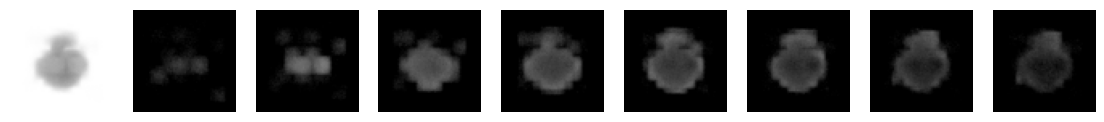

In [19]:
# Render intermediate results
intermediate_im_transient = mi.render(scene, sensor=sensors[0], spp=512)

fig, axs = plt.subplots(1, intermediate_im_transient.shape[0], figsize=(14, 4))
for i in range(intermediate_im_transient.shape[0]):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_im_transient[i]))
    axs[i].axis('off')

## Volume upsampling

Upsample the volume grid for a multi-resolution approach. Dr. Jit provides [<code>dr.upsample()</code>][1], a functions for up-sampling tensor and texture data. We can easily create a higher resolution volume by passing the current optimzed tensor and specifying the desired shape (must be powers of two when upsampling `TensorXf`).

[1]: https://drjit.readthedocs.io/en/latest/src/api_reference.html#drjit.upsample

In [21]:
opt[key] = dr.upsample(opt[key], shape=(16, 16, 16))
params.update(opt)

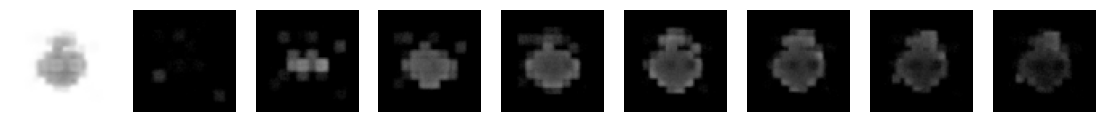

In [22]:
# Render upsampled intermediate results
upscale_im_transient = mi.render(scene, sensor=sensors[0], spp=512)

fig, axs = plt.subplots(1, upscale_im_transient.shape[0], figsize=(14, 4))
for i in range(upscale_im_transient.shape[0]):
    axs[i].imshow(mi.util.convert_to_bitmap(upscale_im_transient[i]))
    axs[i].axis('off')

## Continuing the optimization

In [23]:
for it in range(40):
    total_loss = 0.0

    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        im_transient = mi.render(scene, params, sensor=sensors[sensor_idx], spp=8, seed=it)

        # L2 loss function
        loss = dr.mean(dr.sqr(im_transient - ref_im_transient[sensor_idx]))
        
        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()
        
        # Clamp the optimized density values. Since we used the `scale` parameter 
        # when instantiating the volume, we are in fact optimizing extinction 
        # in a range from [1e-6 * scale, scale].
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        
        # Propagate changes to the scene
        params.update(opt)
        
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

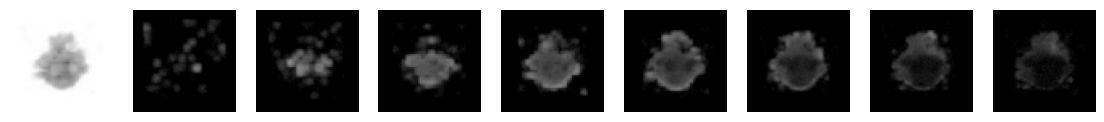

In [24]:
# Render results
intermediate_im_transient = mi.render(scene, sensor=sensors[0], spp=512)

fig, axs = plt.subplots(1, intermediate_im_transient.shape[0], figsize=(14, 4))
for i in range(intermediate_im_transient.shape[0]):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_im_transient[i]))
    axs[i].axis('off')

## Final results

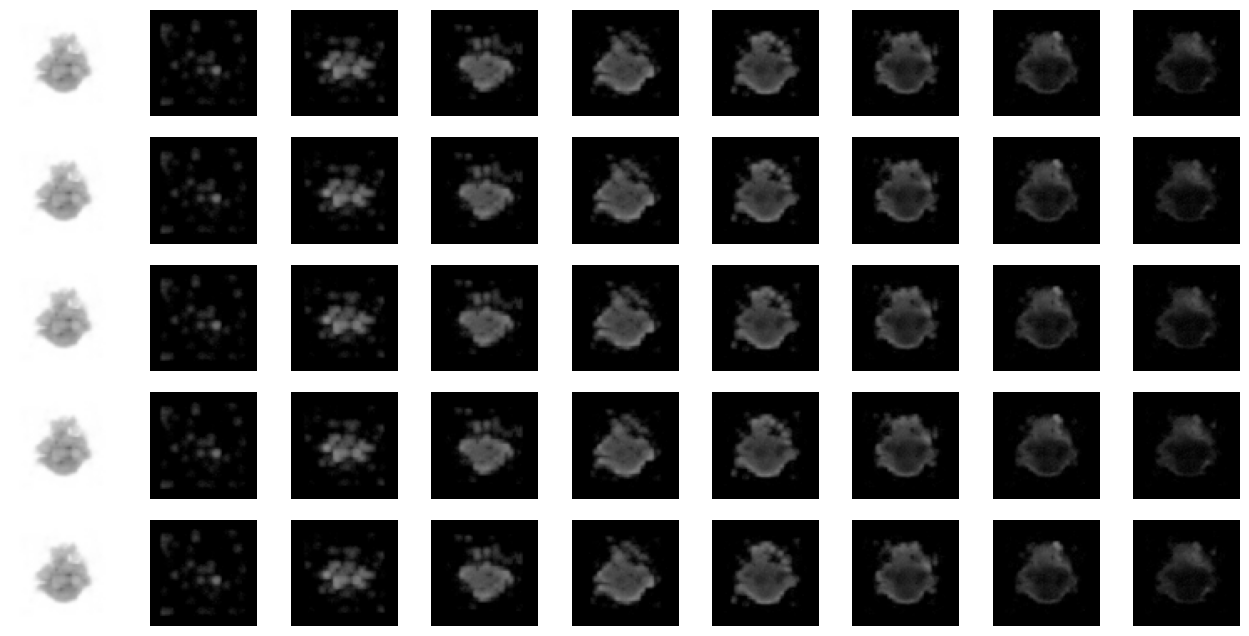

In [90]:
# Render results for all sensors
final_im_transient = [mi.render(scene, sensor=sensors[0], spp=512) for i in range(sensor_count)]

fig, axs = plt.subplots(len(final_im_transient), final_im_transient[0].shape[0], figsize=(16, 8))
for i in range(len(final_im_transient)):
    for j in range(final_im_transient[0].shape[0]):
        axs[i][j].imshow(mi.util.convert_to_bitmap(final_im_transient[i][j]))
        axs[i][j].axis('off')

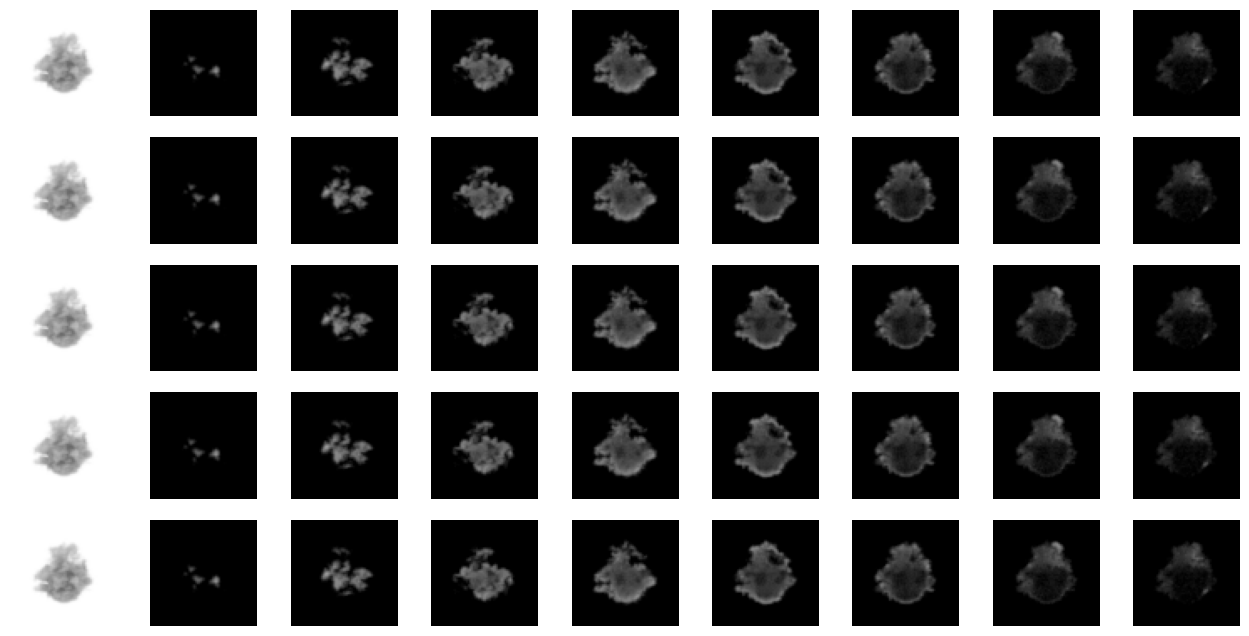

In [5]:
# Render references for all sensors
final_im_transient = [mi.render(scene_ref, sensor=sensors[0], spp=512) for i in range(sensor_count)]

fig, axs = plt.subplots(len(final_im_transient), final_im_transient[0].shape[0], figsize=(16, 8))
for i in range(len(final_im_transient)):
    for j in range(final_im_transient[0].shape[0]):
        axs[i][j].imshow(mi.util.convert_to_bitmap(final_im_transient[i][j]))
        axs[i][j].axis('off')